# Create embeddings and store in Chroma using Open CLIP

## Load Libraries

In [1]:
import open_clip
import torch
from open_clip import transform

from torch.utils.data import Dataset, DataLoader
from PIL import Image
from chromadb.utils.data_loaders import ImageLoader

import csv

import chromadb
from chromadb.utils import embedding_functions

import pandas as pd
from sklearn.model_selection import train_test_split

torch.cuda.empty_cache()
import os

from transformers import AutoTokenizer, AutoModelForCausalLM
from langchain.llms import HuggingFacePipeline

## Initialize the CLIP model

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms(
    model_name="ViT-B-32", pretrained="openai", device=device
)
tokenizer = open_clip.get_tokenizer(model_name="ViT-B-32")

## Instantiate the chroma db 

This step creates a chroma db if it does not exist, or opens an existing database.

In [3]:
chroma_client = chromadb.PersistentClient(path="clip_textdb")

# creating collection for text
text_collection = chroma_client.get_or_create_collection(
    "Text_Store", metadata={"hnsw:space": "cosine"}
)

# creating collection for images
image_collection = chroma_client.get_or_create_collection(
    name="Image_Store", metadata={"hnsw:space": "cosine"}
)

## Load data - If DB is not created

In [4]:
text_collection.count(), image_collection.count()

(50000, 50000)

# Retriever
- This retrieves similar products from the database
- Functions are defined to retrieve data after searching through the databases

In [5]:
def get_inputtextembedding(query):
    """
    This user defined function searches the text collection and retrieves 5 products
    that are most similar in the text description.
    """
    # query is encoded before retrieving from the database
    tokentext = tokenizer(query).to(device)
    with torch.no_grad(), torch.cuda.amp.autocast():
        query_features = model.encode_text(tokentext)
        query_features /= query_features.norm(dim=-1, keepdim=True)
    queryemb = query_features.tolist()

    res = text_collection.query(
        query_embeddings=queryemb,
        n_results=5,
    )
    print(res)
    i = res["ids"]
    for j in i[0]:
        im = "50KImages/" + j + ".jpg"
        img2 = Image.open(im)
        display(img2)
    return res


def get_inputimageembedding(image):
    """
    This user defined function searches the image collection and retrieves 5 products
    that are most similar to the image.
    """
    # the query image is encoded before retrieving from the database
    img = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad(), torch.cuda.amp.autocast():
        query_features = model.encode_image(img)
    queryemb = query_features.tolist()

    res2 = image_collection.query(
        query_embeddings=queryemb,
        n_results=5,
        include=["uris", "metadatas", "distances"],
    )
    print(res2)
    i = res2["ids"]
    for j in i[0]:
        im = "50KImages/" + j + ".jpg"
        img2 = Image.open(im)
        display(img2)
    return res2


def get_data(res, res2):
    Data = ""
    for i in range(0, 5):
        price = res["metadatas"][0][i]["price"]
        Data += (
            "Distance: " + str(res["distances"][0][i]) + ", Price:" + str(price) + "\n"
        )
    for i in range(0, 5):
        price = res2["metadatas"][0][i]["price"]
        Data += (
            "Distance: " + str(res2["distances"][0][i]) + ", Price:" + str(price) + "\n"
        )
    return Data

# Generator

## Setting up LLMs for price Range predictions
* Gemini - pro
* Mixtral

In [6]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.llms import HuggingFaceEndpoint
from langchain.prompts import PromptTemplate, ChatPromptTemplate
from langchain import LLMChain

In [7]:
# Instantiate langsmith for visualizing metrivs
langchain_api_key = "YOUR_API_KEY"
os.environ["LANGCHAIN_API_KEY"] = langchain_api_key
os.environ["LANGCHAIN_PROJECT"] = "price-discovery"
os.environ["LANGCHAIN_TRACING_V2"] = "true"

In [8]:
# Setup google api
GOOGLE_API_KEY = "YOUR_API_KEY"
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

llm = ChatGoogleGenerativeAI(
    model="gemini-pro", google_api_key=GOOGLE_API_KEY, temperature=0.3
)

In [9]:
HUGGINGFACEHUB_API_TOKEN = "YOUR_API_KEY"
os.environ["HUGGINGFACEHUB_API_TOKEN"] = HUGGINGFACEHUB_API_TOKEN

repo_id = "mistralai/Mixtral-8x7B-Instruct-v0.1"

llm_two = HuggingFaceEndpoint(repo_id=repo_id)

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to C:\Users\taman\.cache\huggingface\token
Login successful


In [10]:
test_prompt1 = """
As an experienced product analyst proficient in determining accurate product price ranges precisely,
Your task is to determine product price range based on a user request {input} by considering the retrieved data{Data}.

Step 1: Begin by picking the most similar products from collections {Data} retrieved from the database and use them to come up with an accurate price range

Step 2: Similar products are those with closely matching specifications based on product information and brand. 
Based on this comparison, generate a highly accurate, reasonable, and compact estimate of the price range for the product

Step 4: Return ONLY the ESTIMATE of the PRICE RANGE for the product. use the following example of price range is $100-110 if the price of the product being $106
Return a response with the following reasoning steps and final output to the user:

Step 1: <Step 1 reasoning>
Step 2: <Step 2 reasoning>
Step 3: <final response>

Begin!

"""

In [11]:
# Create prompt template from prompts

prompt_template = PromptTemplate.from_template(test_prompt1)

## Price range Prediction from user query (text)

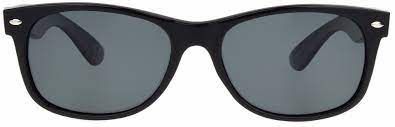

In [12]:
query = "women's sunglasses"
image = Image.open(f"test images/sunglasses.jpg")
display(image)

### Retrieve data

C:\Users\taman\anaconda3\Lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


{'ids': [['B07D9RG4MW', 'B089FQVTFN', 'B07G5K8ST2', 'B07NVVVKD2', 'B07MTMZ38Z']], 'distances': [[0.02607734687626362, 0.02607734687626362, 0.02607734687626362, 0.0394807793200016, 0.04238685593008995]], 'metadatas': [[{'category': '112', 'price': '159.74'}, {'category': '112', 'price': '49.0'}, {'category': '120', 'price': '138.31'}, {'category': '120', 'price': '62.69'}, {'category': '120', 'price': '53.95'}]], 'embeddings': None, 'documents': [["Women's Modern Sunglasses", "Women's Modern Sunglasses", "Women's Modern Sunglasses", "Women's Asian Sunglasses", "Women's Contemporary Sunglasses"]], 'uris': None, 'data': None}


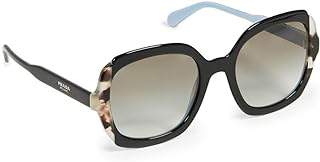

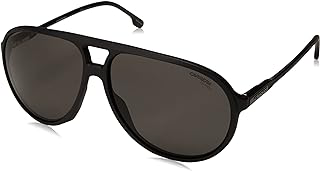

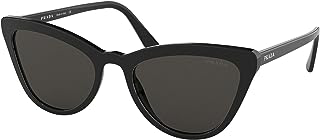

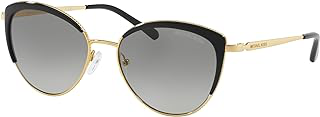

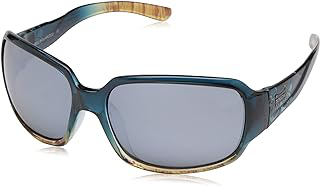

{'ids': [['B0160D1R5C', 'B08XB368QK', 'B0C1THYSKD', 'B00Y43YHFS', 'B005R2MI74']], 'distances': [[0.026617765426635742, 0.03130584955215454, 0.03301721811294556, 0.033117830753326416, 0.034100115299224854]], 'metadatas': [[{'category': '112', 'price': '36.85'}, {'category': '112', 'price': '367.0'}, {'category': '112', 'price': '29.77'}, {'category': '112', 'price': '39.09'}, {'category': '120', 'price': '134.31'}]], 'embeddings': None, 'documents': None, 'uris': [['50KImages/B0160D1R5C.jpg', '50KImages/B08XB368QK.jpg', '50KImages/B0C1THYSKD.jpg', '50KImages/B00Y43YHFS.jpg', '50KImages/B005R2MI74.jpg']], 'data': None}


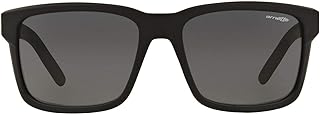

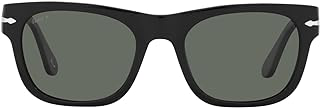

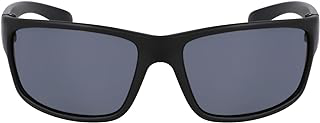

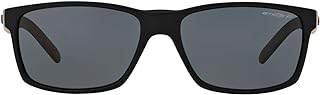

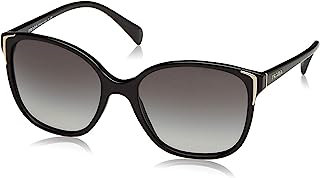

Distance: 0.02607734687626362, Price:159.74
Distance: 0.02607734687626362, Price:49.0
Distance: 0.02607734687626362, Price:138.31
Distance: 0.0394807793200016, Price:62.69
Distance: 0.04238685593008995, Price:53.95
Distance: 0.026617765426635742, Price:36.85
Distance: 0.03130584955215454, Price:367.0
Distance: 0.03301721811294556, Price:29.77
Distance: 0.033117830753326416, Price:39.09
Distance: 0.034100115299224854, Price:134.31



In [13]:
### Retrieve using text embeddings in the text collection

result = get_inputtextembedding(query)

### Retrieve using image embeddings in the image collection

results = get_inputimageembedding(image)


Data = get_data(result, results)

print(Data)

### Generate the result

In [14]:
llm_chain = LLMChain(prompt=prompt_template, llm=llm_two)

# price range with just the query
answer = llm_chain.invoke(
    {
        "Data": f"retrieved data{Data}",
        "input": f"what is the estimated, accurate and compact price range of a/an {query}. Return the price range in the format {{'price_range':{{}}}}",
    }
)

In [15]:
print(answer["text"])

Step 1: To begin determining the price range for a women's sunglasses, we first gather similar products based on their specifications and brand. 

Similar products have been retrieved from the database and are as follows:

{
'similar_products':[
{
'Distance': 0.02607734687626362,
'Price': 159.74
},
{
'Distance': 0.02607734687626362,
'Price': 49.0
},
{
'Distance': 0.02607734687626362,
'Price': 138.31
},
{
'Distance': 0.0394807793200016,
'Price': 62.69
},
{
'Distance': 0.04238685593008995,
'Price': 53.95
},
{
'Distance': 0.026617765426635742,
'Price': 36.85
},
{
'Distance': 0.03130584955215454,
'Price': 367.0
},
{
'Distance': 0.03301721811294556,
'Price': 29.77
},
{
'Distance': 0.033117830753326416,
'Price': 39.09
},
{
'Distance': 0.034100115299224854,
'Price': 134.31
}
]
}

Step 2: We now compare the prices of these similar products. The prices range from $29.77 to $367.0. 
In order to provide a reasonable and compact price range, we consider the median price,


**The above result is obtained by only passing the queried text description.**
- **LLM = Mixtral**

## Price Range Prediction Using a Generated Description
- Robust description is generated from the test query and the image query using an LLM
- The newly generated description will now be passed onto our initial RAG LLM
    - LLM1 = gemini-pro-vision
    - RAG LLM2 = Mixtral
  

### Setting the LLM for the intermediate step of description generation

In [16]:
import PIL
import google.generativeai as genai

genai.configure(api_key=os.environ["GOOGLE_API_KEY"])

In [17]:
vision_model = genai.GenerativeModel(
    "gemini-pro-vision", generation_config={"temperature": 0.3}
)

In [18]:
response1 = vision_model.generate_content(
    [
        f"Given the description of the product as {query}, extract details about the product in the image such as brand and color and your thought on quality etc. Then generate a searcheable prompt about the product that I can feed to google to get this exact product. Return ONLY the searchable prompt in the format{{'search_prompt':{{}}}} ",
        image,
    ]
)
response2 = vision_model.generate_content(
    [
        f"Given me an adequate and approximate description of the product in the image in fifteen words ",
        image,
    ]
)

Detailed Description: 

  The image shows a pair of black plastic sunglasses with a rectangular frame and dark gray lenses. The sunglasses are likely to be made of plastic and are probably lightweight and durable. The sunglasses are a classic style and would be suitable for a variety of face shapes.

Search prompt:
{women's black plastic sunglasses rectangular frame dark gray lenses}
Concise Description 

  Black semi-rimless sunglasses with a rectangular frame and dark gray lenses.


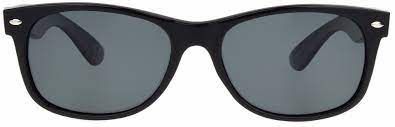

In [19]:
description1 = response1.text
print("Detailed Description: \n\n", description1)
print("=" * 100)
description2 = response2.text
print("Concise Description \n\n", description2)

display(image)

#### Retrieve new data

{'ids': [['B0BYCVK1GQ', 'B0BYCTHXVK', 'B0068QEEHU', 'B00Y43YHFS', 'B0B455GMD6']], 'distances': [[0.5046855807304382, 0.5092503428459167, 0.5160884857177734, 0.5222495198249817, 0.5254773497581482]], 'metadatas': [[{'category': '112', 'price': '109.64'}, {'category': '120', 'price': '156.77'}, {'category': '120', 'price': '206.74'}, {'category': '112', 'price': '39.09'}, {'category': '120', 'price': '99.55'}]], 'embeddings': None, 'documents': [['Unisex Sunglasses Grey On Black Frame, Black Lenses, 50MM', 'Woman Sunglasses Black Frame, Dark Grey Lenses, 55MM', 'Sunglasses - Whitney / Frame: Shiny Black Lens: Smoke Polarized, 64-14-110', 'Unisex Sunglasses Shiny Black Frame, Polarized Dark Grey Lenses, 58MM', 'Woman Sunglasses Black Frame, Dark Grey Lenses, 56MM']], 'uris': None, 'data': None}


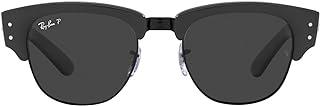

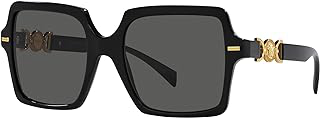

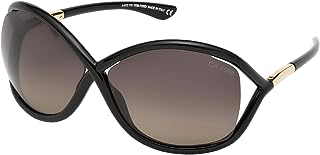

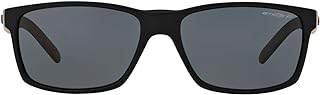

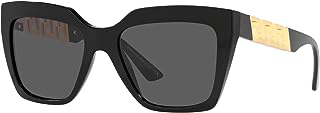

{'ids': [['B0160D1R5C', 'B08XB368QK', 'B0C1THYSKD', 'B00Y43YHFS', 'B005R2MI74']], 'distances': [[0.026617765426635742, 0.03130584955215454, 0.03301721811294556, 0.033117830753326416, 0.034100115299224854]], 'metadatas': [[{'category': '112', 'price': '36.85'}, {'category': '112', 'price': '367.0'}, {'category': '112', 'price': '29.77'}, {'category': '112', 'price': '39.09'}, {'category': '120', 'price': '134.31'}]], 'embeddings': None, 'documents': None, 'uris': [['50KImages/B0160D1R5C.jpg', '50KImages/B08XB368QK.jpg', '50KImages/B0C1THYSKD.jpg', '50KImages/B00Y43YHFS.jpg', '50KImages/B005R2MI74.jpg']], 'data': None}


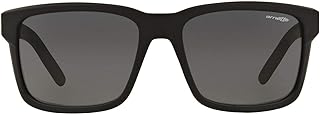

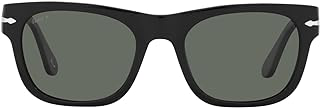

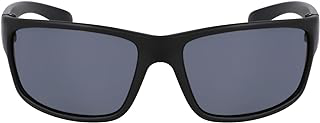

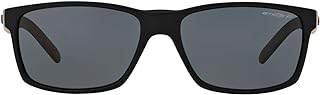

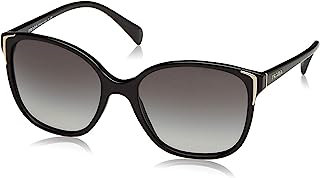

Distance: 0.5046855807304382, Price:109.64
Distance: 0.5092503428459167, Price:156.77
Distance: 0.5160884857177734, Price:206.74
Distance: 0.5222495198249817, Price:39.09
Distance: 0.5254773497581482, Price:99.55
Distance: 0.5046855807304382, Price:109.64
Distance: 0.5092503428459167, Price:156.77
Distance: 0.5160884857177734, Price:206.74
Distance: 0.5222495198249817, Price:39.09
Distance: 0.5254773497581482, Price:99.55



In [20]:
new_result1 = get_inputtextembedding(description1)
new_results1 = get_inputimageembedding(image)

Data1 = get_data(new_result1, new_result1)
print(Data1)

{'ids': [['B0BYCVK1GQ', 'B077K9FKR7', 'B0BYCTHXVK', 'B09XJ9HTFQ', 'B07S2WQ3FG']], 'distances': [[0.2595566213130951, 0.27345025539398193, 0.2755756378173828, 0.27731701731681824, 0.2788662612438202]], 'metadatas': [[{'category': '112', 'price': '109.64'}, {'category': '120', 'price': '266.35'}, {'category': '120', 'price': '156.77'}, {'category': '112', 'price': '124.99'}, {'category': '112', 'price': '129.99'}]], 'embeddings': None, 'documents': [['Unisex Sunglasses Grey On Black Frame, Black Lenses, 50MM', 'Unisex Sunglasses Black Matte Frame, Grey Lenses, 61MM', 'Woman Sunglasses Black Frame, Dark Grey Lenses, 55MM', 'Man Sunglasses Black Frame, Dark Grey Lenses, 52MM', 'Man Sunglasses Black Frame, Dark Grey Lenses, 58MM']], 'uris': None, 'data': None}


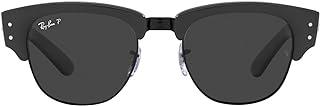

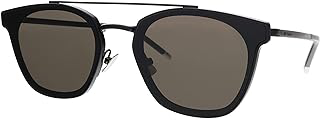

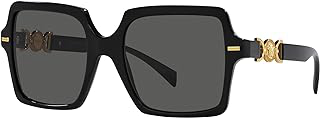

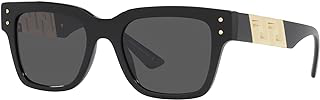

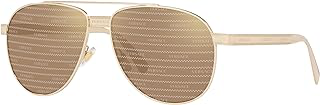

{'ids': [['B0160D1R5C', 'B08XB368QK', 'B0C1THYSKD', 'B00Y43YHFS', 'B005R2MI74']], 'distances': [[0.026617765426635742, 0.03130584955215454, 0.03301721811294556, 0.033117830753326416, 0.034100115299224854]], 'metadatas': [[{'category': '112', 'price': '36.85'}, {'category': '112', 'price': '367.0'}, {'category': '112', 'price': '29.77'}, {'category': '112', 'price': '39.09'}, {'category': '120', 'price': '134.31'}]], 'embeddings': None, 'documents': None, 'uris': [['50KImages/B0160D1R5C.jpg', '50KImages/B08XB368QK.jpg', '50KImages/B0C1THYSKD.jpg', '50KImages/B00Y43YHFS.jpg', '50KImages/B005R2MI74.jpg']], 'data': None}


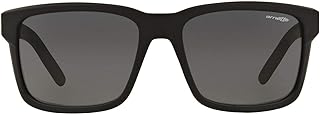

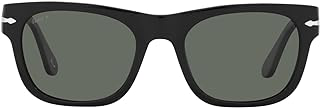

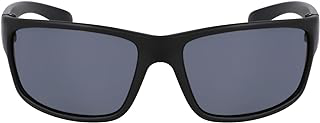

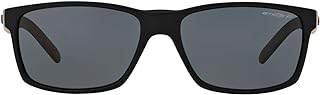

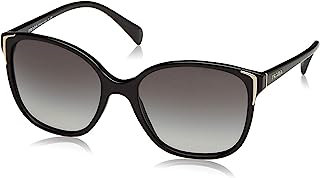

Distance: 0.2595566213130951, Price:109.64
Distance: 0.27345025539398193, Price:266.35
Distance: 0.2755756378173828, Price:156.77
Distance: 0.27731701731681824, Price:124.99
Distance: 0.2788662612438202, Price:129.99
Distance: 0.2595566213130951, Price:109.64
Distance: 0.27345025539398193, Price:266.35
Distance: 0.2755756378173828, Price:156.77
Distance: 0.27731701731681824, Price:124.99
Distance: 0.2788662612438202, Price:129.99



In [21]:
new_result2 = get_inputtextembedding(description2)
new_results2 = get_inputimageembedding(image)

Data2 = get_data(new_result2, new_result2)
print(Data2)

#### Generate new result

In [22]:
answer1 = llm_chain.invoke(
    {
        "Data": f"retrieved data{Data1}",
        "input": f"what is the estimated, accurate and compact price range of a/an {description1}. Return the price range in the format {{'price_range':{{}}}}",
    }
)
print(answer1["text"])

Step 1: The most similar products are selected based on the closest distance, and those products are:
- Distance: 0.5046855807304382, Price:109.64
- Distance: 0.5092503428459167, Price:156.77
- Distance: 0.5160884857177734, Price:206.74
- Distance: 0.5222495198249817, Price:39.09
- Distance: 0.5254773497581482, Price:99.55
- Distance: 0.5046855807304382, Price:109.64
- Distance: 0.5092503428459167, Price:156.77
- Distance: 0.5160884857177734, Price:206.74
- Distance: 0.5222495198249817, Price:39.09
- Distance: 0.5254773497581482, Price:99.55

Step 2: Based on the above selection, the most similar products are those with rectangular frames and dark gray lenses.
This means that the estimated price range is between the lowest and highest price of these products, which is:

$39.09 - $206.74

Step 3: However, this price range is too broad. It is better to narrow down the price range to the most reasonable and compact estimate.
Therefore, a more accurate estimate of the price range is:

$99.

**The above answer is the result of a detailed description obtained from the vision LLM**

In [23]:
answer2 = llm_chain.invoke(
    {
        "Data": f"retrieved data{Data2}",
        "input": f"what is the estimated, accurate and compact price range of a/an {description2}. Return the price range in the format {{'price_range':{{}}}}",
    }
)
print(answer2["text"])

Step 1: The most similar products to the requested Black semi-rimless sunglasses with a rectangular frame and dark gray lenses are the products with a low distance value in the retrieved data. The lowest distance value is 0.2595566213130951, indicating the most similar product. 

Step 2: Based on the retrieved data, the prices of the most similar products are: $109.64, $124.99, $129.99, $156.77, $266.35. To estimate a reasonable and compact price range, we will select the minimum and maximum values, which are $109.64 and $266.35, respectively.

Step 3: The estimated price range for the requested Black semi-rimless sunglasses with a rectangular frame and dark gray lenses is $109.64 - $266.35.

{'price_range': {'min': 109.64, 'max': 266.35}}


**The above answer is the result of the concise description obtained from the vision LLM.**